# Time Series Prediction


In [3]:
# @ Lukman copyright 
# MIT Licence

In [98]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *
from tensorflow.keras import regularizers

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random

import yaml
import os
from utility import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# mlflow
import mlflow.keras

mlflow.keras.autolog()

In [16]:
# enable eager executinon
tf.enable_eager_execution()

In [17]:
tf.__version__

'1.15.0'

# Load And  Preprocess Data

In [18]:
################################################################################
# load config file
try:
    with open("../config.yml", 'r') as ymlfile:
            cfg = yaml.safe_load(ymlfile)
except (IOError):
    print('config file is required. Put config file in current directory')
################################################################################

In [19]:
# boolean for preprocessing datasets for tensorflow
tfreprocess = cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfprocess']

In [34]:
# current working directory
cwd = os.getcwd()
# set the base directory. base directo
BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# cleaned data dir
cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV2']['cleanedDir'] 
# clean data Name
cleandataName = cfg['cleanedconfig']['cleanedDataV2']['cleanedName']
# traina and validation data name
trainName= cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanTrain']
validateName  = cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanValidate']
validation_split = cfg['cleanedconfig']['cleanedDataV2']['validationSplit']

In [35]:
# You might not need to reprocess if
# u want to reuse the data set
# if to re-assess the data pipeline the click yes


In [36]:
direct_load = True
if tfreprocess:
    
    _,_,data_types,col_names= utils.tfdatabuilder(cleanedpath,cleandataName,trainName, validateName,validation_split )
    
elif not direct_load:
    ## I commented this out to facilitate easy training
    train = pd.read_csv(cleanedpath + trainName) 
    data_types,col_names = utils.tfpreprocess(train)
else:
    # data types for training. data types are here converted to tensorflow datatype
    data_types = [tf.float64, tf.float64, tf.float64, tf.float64, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32, tf.int32]
    col_names = ['meter_reading','square_feet','air_temperature','dew_temperature','month','day','hour','primary_use_Education',
             'primary_use_Entertainment/public assembly','primary_use_Food sales and service','primary_use_Healthcare',
             'primary_use_Lodging/residential','primary_use_Manufacturing/industrial','primary_use_Office','primary_use_Other',
             'primary_use_Parking','primary_use_Public services','primary_use_Religious worship','primary_use_Retail',
             'primary_use_Services','primary_use_Technology/science','primary_use_Utility','primary_use_Warehouse/storage',
             'site_id_0','site_id_1','site_id_2','site_id_3','site_id_4','site_id_5','site_id_6','site_id_7','site_id_8',
             'site_id_9','site_id_10','site_id_11','site_id_12','site_id_13','site_id_14','site_id_15']

#### Work with downloaded csv to preserve data type
Load the csv file and parse the data types of the datatset together into the
tensorflow load pipeline

In [37]:
# load the data using the tensorflow Dataset API
# add the data types too
csvData = tf.data.experimental.CsvDataset(cleanedpath + trainName, data_types, header=True)

In [38]:
# check the data type :
#print(list(csvData.take(1)))

In [39]:
# use this index to know configure how to batch the
# categorical variables 
#col_names

In [40]:
# categorical features to use 
catfeatures = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['categoricalFeatureToUse']
catNames = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['CategoricalFeature']



#### Parse data 

In [41]:
# Parsing the data and
# merging the columns:
# ---- day and month as single column
# ---- merge the site id as a single feature vector vector
# ---- primary use as a single feature vector

# take the forst 4 col names that meter reading, square feet, air temp , dew temp,
# add it to a the new column names that would be formed after single column merging

#categorical feature selection
# here one can decide if to use site id or not . Site id is index 2 from catnames
if catfeatures == 3:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1],catNames[2] ]
else:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1]]

def _parse_csv_row(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:23]) # this index can be chage but ensure consistency 
    if catfeatures == 3:
        # site id as single feature
        site_id =  tf.convert_to_tensor(vals[23:39])
    
        # merge the features together, note meter reading is the fist column
        # so it is excluded -- meaning index starts from 1
        feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    else:
        feature_vals = vals[1:4] + (month_day,primary_use)
        
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features, targets_tensor

##### Batch the datatset

In [42]:

dataset = csvData.map(_parse_csv_row).batch(64)

In [43]:

#print(list(dataset.take(1)))

##### Feature Categorization

In [44]:
primary_use = tf.feature_column.numeric_column(catNames[1], shape=(16,))
site_id = tf.feature_column.numeric_column(catNames[2], shape=(16,))
month_day = tf.feature_column.numeric_column(catNames[0], shape=(3,))

In [45]:
numeric_columns = [tf.feature_column.numeric_column(feat) for feat in col_names_[1:4]]

In [46]:
columns = numeric_columns + [month_day,primary_use,site_id]

In [47]:
feature_layer = tf.keras.layers.DenseFeatures(columns)

# Build Model

In [48]:
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import  NonNeg

def root_mean_squared_error(y_true, y_pred):
    '''
    
    this is the loss function specified in kaggle competition
    '''
        
    return K.sqrt(K.mean (K.square(  (K.log(K.abs(y_pred)+1)- K.log(y_true+1)) )   )   )



def root_mean_squared_error2(y_true, y_pred):
    '''
    this is 1.- mean squared
    root mean squared is a value between 0 and 1 
    to reflect accuracy use 1-rms
    '''
        
    return  K.sqrt(K.mean( ( K.square ( y_pred - y_true    )   )   )) 

In [49]:
# model layer 
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,kernel_regularizer=regularizers.l2(1e-2),kernel_constraint=NonNeg()),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(8,activation='relu',kernel_constraint=NonNeg()),
    tf.keras.layers.Dense(4,activation='relu',kernel_constraint=NonNeg()),
    tf.keras.layers.Dense(2,kernel_regularizer=regularizers.l2(1e-2),kernel_constraint=NonNeg()),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear',kernel_constraint=NonNeg())
])


In [50]:
model.compile(optimizer = tf.train.AdagradOptimizer(1e-4),
             loss=root_mean_squared_error)

# error ranges value 1e-2 to 1e-4 for good performance

# Optimizer to use '''''' AdagradOptimizer and root_mean_squared_error2 ranges 1
# Adam --- not good
# Adam
#Rmsprop


In [51]:
import os
checkpoint_path = cfg['savedModel']['myname2']['Dir'] + cfg['savedModel']['myname2']['modelName']
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_dir


'savedModels/tfAPIKeras2'

In [52]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [53]:
train_epochs = 5# increase this to train data better
restore = False
# for loop trains incrementally
# this issue https://github.com/keras-team/keras/issues/4446
for i in range(train_epochs):  
    if restore:
        model.load_weights(checkpoint_path)
    model.fit(dataset,epochs=10,steps_per_epoch=40,callbacks=[cp_callback])
    restore = True
    


Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_utils.py:1291: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(sample_weight_mode, collections.Mapping):
/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(values, collections.Sequence):


33/40 [=======================>......] - ETA: 0s - loss: 6.2783
Epoch 00001: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 2s 39ms/step - loss: 6.2968
Epoch 2/10
35/40 [=========================>....] - ETA: 0s - loss: 6.3893
Epoch 00002: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 6.3826
Epoch 3/10
39/40 [============================>.] - ETA: 0s - loss: 6.2958
Epoch 00003: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 6.3006
Epoch 4/10
33/40 [=======================>......] - ETA: 0s - loss: 6.3584
Epoch 00004: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 6.3589
Epoch 5/10
35/40 [=========================>....] - ETA: 0s - loss: 6.3141
Epoch 00005: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [===========

Epoch 10/10
34/40 [========================>.....] - ETA: 0s - loss: 5.9713
Epoch 00010: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 5.9583
Epoch 1/10
32/40 [=======================>......] - ETA: 0s - loss: 5.9767
Epoch 00001: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 5.9706
Epoch 2/10
33/40 [=======================>......] - ETA: 0s - loss: 5.9481
Epoch 00002: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 5.9587
Epoch 3/10
33/40 [=======================>......] - ETA: 0s - loss: 5.9417
Epoch 00003: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [==============================] - 0s 7ms/step - loss: 5.9586
Epoch 4/10
32/40 [=======================>......] - ETA: 0s - loss: 5.9244
Epoch 00004: saving model to savedModels/tfAPIKeras2/tfAPIKeras.ckpt
40/40 [

## Testing

In [54]:
# The test below is not yet working

In [62]:
def _parse_csv_row2(*vals):
    '''
    Uses Feature columns
    Does feature engineering
    '''
    
    # month and day and single feature
    month_day = tf.convert_to_tensor(vals[4:7])
    # primary use as single feature
    primary_use = tf.convert_to_tensor(vals[7:23])
    # site id as single feature
    site_id =  tf.convert_to_tensor(vals[23:39])
    
    # merge the features together, note meter reading is the fist column
    # so it is excluded -- meaning index starts from 1
    feature_vals = vals[1:4] + (month_day,primary_use,site_id)
    
    
    # zip into a  feature sets into a single col
    features = dict(zip(col_names_[1:],feature_vals))
    
    # name the targets or lables
    targets_tensor = tf.convert_to_tensor(vals[0],name=col_names_[0]) 
    
    
    
    return features

In [63]:
# test data path
testpath= BASE_DIR + cfg['cleanedtest']['TargetDir']
testDataName= cfg['cleanedtest']['testFeatureSet']
testName = cfg['cleanedtest']['testData']
testzero =  cfg['cleanedtest']['testDatasetName']

In [64]:
# read test data
if tfreprocess:
    
    data_types, col_names = utils.tfdatabuilder(testpath,testDataName,testName, validateName,validation_split,test=True )
    
else:
    pass
    #test = pd.read_csv(testpath + testName) 
    

In [65]:
# categorical features to use 
catfeatures = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['categoricalFeatureToUse']
catNames = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['CategoricalFeature']
if catfeatures == 3:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1],catNames[2] ]
else:
    col_names_= [col_names[0],col_names[1],col_names[2],col_names[3],catNames[0],catNames[1]]

In [66]:
testdata = tf.data.experimental.CsvDataset(testpath + testName, data_types, header=True) # set header to true

In [67]:
test = testdata.map(_parse_csv_row2).batch(1)

In [68]:
# predicitons 
predictions = model.predict(test)

In [69]:
# upload true meter reADINGS
true_readings = pd.read_csv(testpath + testzero) 
del true_readings['Unnamed: 0']

In [70]:
true_readings.head()

,meter_reading,building_id,timestamp
0,173.370293,0,2017-01-01 00:00:00
1,53.512720,1,2017-01-01 00:00:00
2,6.143042,2,2017-01-01 00:00:00
3,101.701470,3,2017-01-01 00:00:00
4,1141.240666,4,2017-01-01 00:00:00


In [71]:
# get true values
true_values=true_readings['meter_reading'].values

Text(0.5, 0, 'Iterations')

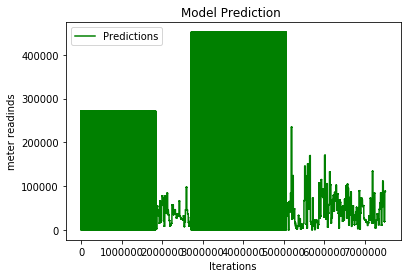

In [72]:
plt.plot(predictions,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('Model Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

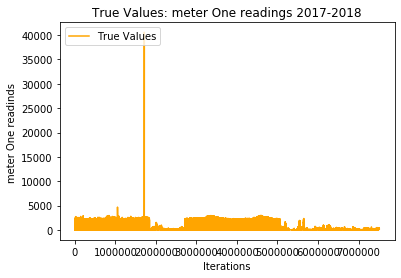

In [73]:
#plt.plot(predictions,"-g" ,label='Predictions')
plt.plot(true_values, "-r",label='True Values',color='orange')
plt.legend(loc="upper left")
plt.title('True Values: meter One readings 2017-2018')
plt.ylabel('meter One readinds ')
plt.xlabel('Iterations')

In [74]:
test_predicted = pd.DataFrame(list(zip(list(true_readings.building_id),list(true_readings.timestamp),list(predictions))),columns= ['building_id','timestamp', 'meter_reading' ] )

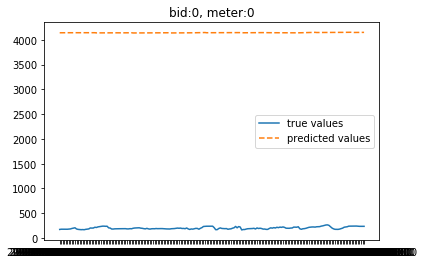

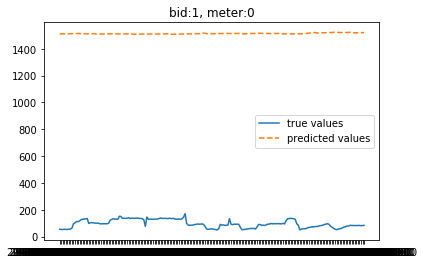

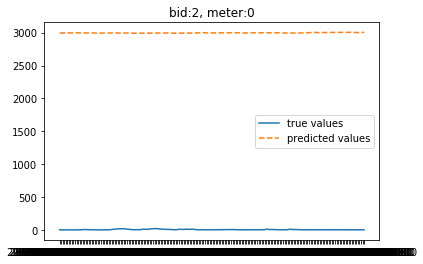

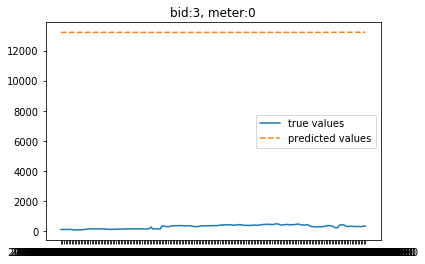

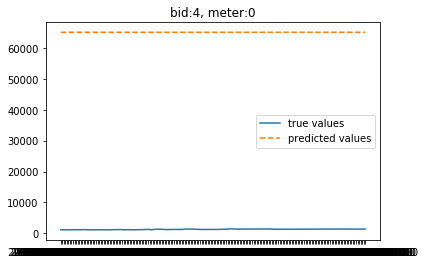

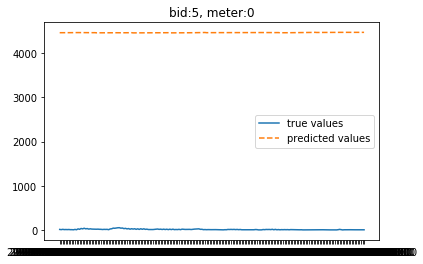

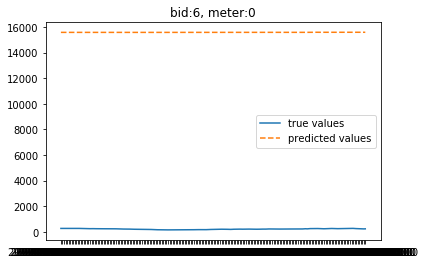

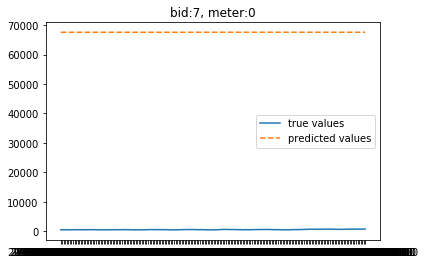

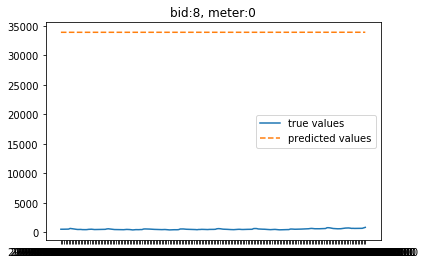

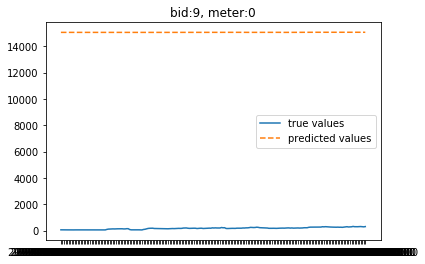

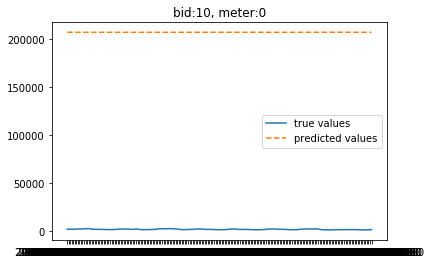

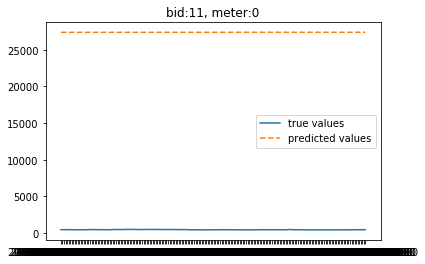

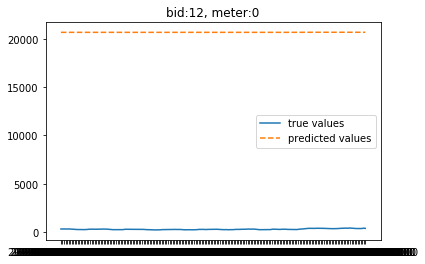

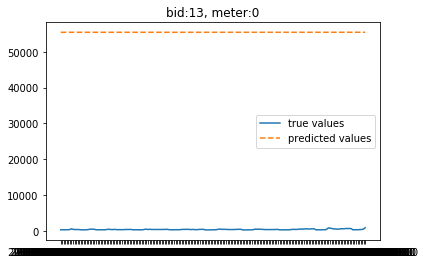

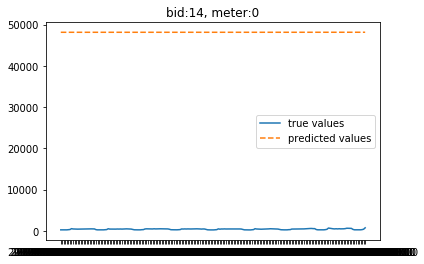

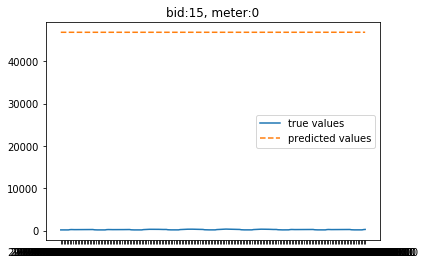

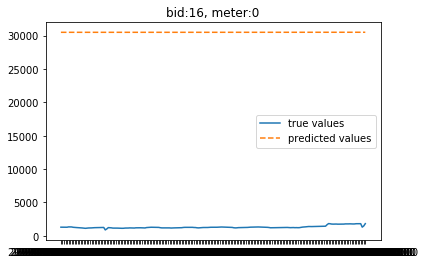

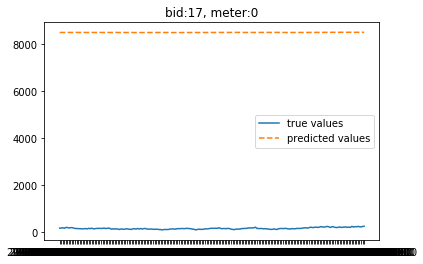

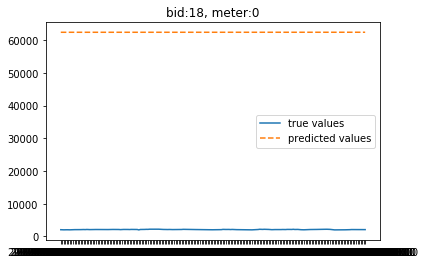

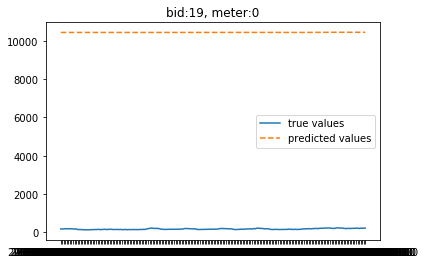

In [99]:
utils.plot_meter(true_readings,test_predicted,bn=20)